<a href="https://colab.research.google.com/github/pallavi-allada/UtteranceClassification/blob/main/src/Word2Vec_Utterance_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read the train and test data from stratified splits done earlier.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os as os

import matplotlib.pyplot as plt
import seaborn as sns

import string, re
import pickle 

import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/Cognizer"
DATA_DIR = "data"
MODEL_DIR = "models"

TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"

WORD2VEC_BIN = "GoogleNews-vectors-negative300.bin"

First view of data dimensions - shape and some samples - head


In [ ]:
dataset = pd.read_csv(os.path.join(ROOT_DIR, DATA_DIR, TRAIN_CSV))
dataset.shape

(4137, 3)

There are 4137 records with 3 columns.


In [ ]:
dataset.head()

,question,tags,label
0,What are some services offered by Autodesk?,Document,4
1,Who is benjamin ?,Contact,3
2,How do I contact Mum?,Contact,3
3,when was the Human Resources Master Services A...,Contract,0
4,what is the validity period for a Human Resour...,Contract,0


In [ ]:
#convert tag to label
def tag2label(tag):
  return (0 if tag == "Contract" else (1 if tag == "Email" else (2 if tag == "Calendar" else (3 if tag == "Contact" else (4 if tag == "Document" else (5 if tag == "Employee" else 6))))))

#convert label to tag
def label2tag(lbl):
  return ("Contract" if lbl == 0 else ("Email" if lbl == 1 else ("Calendar" if lbl == 2 else ("Contact" if lbl == 3 else ("Document" if lbl == 4 else ("Employee" if lbl == 5 else "Keyword"))))))


Cleaning question data to remove punctuation.

In [ ]:
 print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
def clean(sent):
  words = [re.sub('[%s]' % re.escape(string.punctuation), '', word) for word in sent.split()]
  return [word for word in words if len(word)>0] 
  
dataset["cleaned"] = dataset["question"].apply(clean)

In [ ]:
dataset.head()

,question,tags,label,cleaned
0,What are some services offered by Autodesk?,Document,4,"[What, are, some, services, offered, by, Autod..."
1,Who is benjamin ?,Contact,3,"[Who, is, benjamin]"
2,How do I contact Mum?,Contact,3,"[How, do, I, contact, Mum]"
3,when was the Human Resources Master Services A...,Contract,0,"[when, was, the, Human, Resources, Master, Ser..."
4,what is the validity period for a Human Resour...,Contract,0,"[what, is, the, validity, period, for, a, Huma..."


In [ ]:
documents = list(zip(dataset["label"].tolist(), dataset["cleaned"]))
print(documents)

[(4, ['What', 'are', 'some', 'services', 'offered', 'by', 'Autodesk']), (3, ['Who', 'is', 'benjamin']), (3, ['How', 'do', 'I', 'contact', 'Mum']), (0, ['when', 'was', 'the', 'Human', 'Resources', 'Master', 'Services', 'Agreements', 'from', 'CA', 'Inc', 'signed']), (0, ['what', 'is', 'the', 'validity', 'period', 'for', 'a', 'Human', 'Resources', 'Master', 'Services', 'Agreements']), (0, ['provide', 'list', 'of', 'agreements', 'between', 'Rely', 'Tech', 'LLC', 'and', 'Twilight', 'Softwares', 'Singapore', 'Pte', 'Ltd']), (6, ['customer', 'service', 'playbook']), (2, ['Who', 'all', 'are', 'attending', 'the', 'discussion', 'on', 'email']), (1, ['What', 'Is', 'my', 'last', 'email']), (0, ['find', 'all', 'the', 'seventeenth', 'amendment', 'to', 'the', 'Verizon', 'Business', 'Service', 'Agreements', 'signed', 'in', 'October', '2018']), (1, ['When', 'did', 'mitchell', 'and', 'I', 'speak', 'at', 'the', 'very', 'beginning']), (1, ['When', 'did', 'richa', 'and', 'I', 'talk', 'last']), (0, ['return

In [ ]:
# Downloaded word2vec bin and copied to drive for future use
# !wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 
# !gunzip GoogleNews-vectors-negative300.bin.gz 
# ! cp /content/GoogleNews-vectors-negative300.bin '/content/drive/MyDrive/Colab Notebooks/Cognizer/'

Load the pretrained word2vec model and retrieve the embeddings from it for the words. Since it's a binary file, we mention binary = True.  Embedding size = 300.

In [ ]:
#use the existing google bin to get word2vec representation
model = gensim.models.KeyedVectors.load_word2vec_format(os.path.join(ROOT_DIR,MODEL_DIR,WORD2VEC_BIN), binary=True, limit=500000)

First we parse through each of the sentences, and retrieve the embeddings for the words and add them together.

In [ ]:
def convert_sentence2vec(documents, isUseZeros):
    missing_word_vecs={}
    word2vec_rep = np.zeros((len(documents), num_features))
    labels = []
    i=0

    for document in documents:
        tag = document[0]
        doc_words = document[1]
        
        for word in doc_words: 
            try:
                word2vec_rep[i]+=model[word]
            except:
                if word  not in missing_word_vecs.keys():
                    if isUseZeros:
                        missing_word_vecs[word] = np.zeros((num_features))
                    else:
                        #Random noise is an alternative but challenges of storing this vector for consistency arrises.
                        missing_word_vecs[word] = np.random.normal(-0.25, 0.25, num_features)
                word2vec_rep[i]+=missing_word_vecs[word]
        labels.append(tag)
        i+=1
    return word2vec_rep, labels, missing_word_vecs

word2vec_representation function is for the test time to convert the sentence to vector.

In [ ]:
def word2vec_representation(doc_words, isUseZeros= True):
    word2vec_rep = np.zeros((1, num_features))
    for word in doc_words: 
        try:
            word2vec_rep+=model[word]
        except:
            if word  not in missing_word_vecs.keys():
                if isUseZeros:
                    missing_word_vecs[word] = np.zeros((num_features))
                else:
                    #Random noise is an alternative but challenges of storing this vector for consistency arrises.
                    missing_word_vecs[word] = np.random.normal(-0.25, 0.25, num_features)
            word2vec_rep+=missing_word_vecs[word]
    return word2vec_rep
            
    

In [ ]:
sent2vec_rep, labels, missing_word_vecs = convert_sentence2vec(documents, True)

In [ ]:
sent2vec_rep.shape, len(labels)

((4137, 300), 4137)

In [ ]:
print("Missing word count:",len(missing_word_vecs))
missing_word_vecs.keys()

Missing word count: 625


dict_keys(['benjamin', 'a', 'of', 'and', 'to', '2018', 'mitchell', 'richa', 'hailey', 'brannans', 'roberts', 'VWi', 'jeswil', 'nathan', 'What’s', '17', 'photoreduction', '20', 'OneProvider', 'Cognizer', 'christopher', 'Osterreich', 'Maithalis', '2020', 'Kloudone', 'Incs', 'valentina', 'taylors', '0271991', 'erics', 'rajiv', 'baronia', 'vinay', 'kumars', '17th', '2015', 'skipbatch', 'Bhangar', 'aaronkpmgcom', '05th', '2013', 'cognizer', 'jira', 'nicholas', 'vivian', 'Adamss', 'bestankit', '2014', 'julia', 'donald', 'bjsjkfh', 'ssnflkshdf', 'dvsfs', 'GmbHs', '202020', 'susies', 'rohit', 'bhimrao', 'ambedkar', 'susie', 'nda', 'rahul', 'Sambandam', 'covid19', 'Netcetera', 'Albares', 'test2', 'dylan', '02', 'Rakshas', 'qna', 'Disussion', 'ankit', 'Nondisclosure', 'aaron', 'johndoecom', 'ammendments', 'Agreementss', 'maithilitqidcom', 'aug', 'Williamss', 'oliver', '2019', 'SOWs', 'Influitive', 'BoxWorks', 'haileys', 'bilberries', 'DPAs', 'eod', 'Media5', 'Jeswil', 'nicholass', 'Permanente', 

We have 625 missing words, and most of these are names, but looks like the fun part is that Word2Vec is case sensitive.

Ex- "Richa" with a capital R is available in the vocab but not "richa". 
Likewise for a few other names  llike  "ankit"

In [ ]:
def word_in_vocab(word):
  try:
    if model[word].shape[0] == 300:
      print("Word %s in vocabulary" % word)
  except KeyError:
    print("Word %s not in vocabulary!" % word)

In [ ]:
word_in_vocab("Richa")
word_in_vocab("richa")

Word Richa in vocabulary
Word richa not in vocabulary!


Now, that we have the vectors in place, let's try different classifiers, and compare metrics.

In [ ]:
#classification problem

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn.fit(sent2vec_rep, labels)

rf = RandomForestClassifier(random_state = 42, n_jobs=-1, class_weight="balanced")
rf.fit(sent2vec_rep, labels);

gbrt = GradientBoostingClassifier(max_depth=3, criterion='mse')
gbrt.fit(sent2vec_rep, labels)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Saving models to disk for future use

In [ ]:
knnPickle = open(os.path.join(ROOT_DIR, MODEL_DIR,'knnpickle_file'), 'wb') 
pickle.dump(knn, knnPickle)    

randomForestPickle = open(os.path.join(ROOT_DIR, MODEL_DIR,'rfpickle_file'), 'wb') 
pickle.dump(rf, randomForestPickle)

gbPickle = open(os.path.join(ROOT_DIR, MODEL_DIR,'gbpickle_file'), 'wb') 
pickle.dump(gbrt, gbPickle)


Retrieving test data from test.csv created earlier through train test split, and converting it to vectors for predictions.

In [ ]:
test = pd.read_csv(os.path.join(ROOT_DIR, DATA_DIR, TEST_CSV))
test.shape

(460, 3)

In [ ]:
test["cleaned"] = test["question"].apply(clean)
documents = list(zip(test["label"].tolist(), test["cleaned"]))
sent2vec_rep, labels, missing_word_vecs = convert_sentence2vec(documents, True)

Getting predictions from various models -

In [ ]:
knn_predictions = knn.predict(sent2vec_rep)
rf_predictions = rf.predict(sent2vec_rep)
gbrt_predictions = gbrt.predict(sent2vec_rep)

## Performance metrics -

In [ ]:
knn_cm = confusion_matrix(labels, knn_predictions)
rf_cm = confusion_matrix(labels, rf_predictions)
gbrt_cm = confusion_matrix(labels, gbrt_predictions)

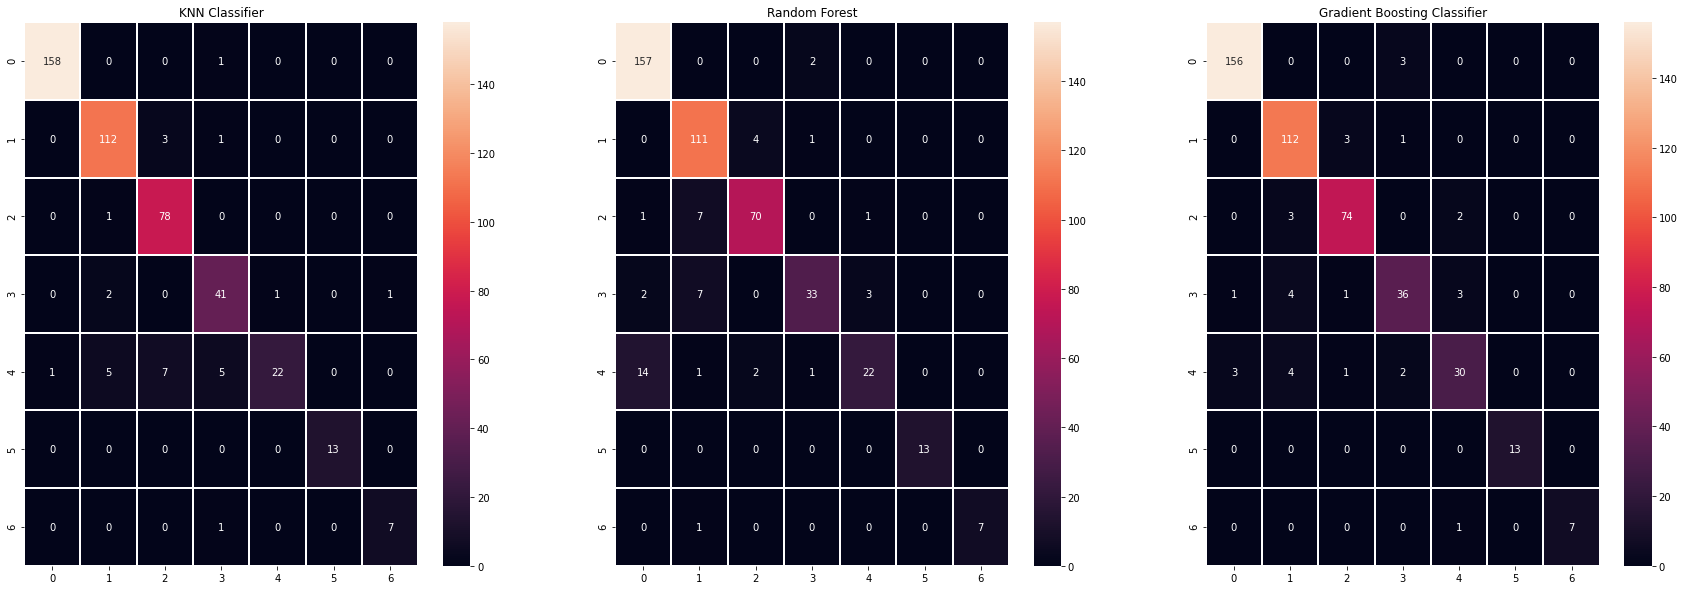

In [ ]:
fig = plt.figure(figsize=(30,10))

#  subplot #1
plt.subplot(131)
plt.title('KNN Classifier')
sns.heatmap(knn_cm, linewidths=1,annot=True, fmt='g')

#  subplot #2
plt.subplot(132)
plt.title('Random Forest')
sns.heatmap(rf_cm, linewidths=1,annot=True, fmt='g')

#  subplot #3
plt.subplot(133)
plt.title('Gradient Boosting Classifier')
sns.heatmap(gbrt_cm, linewidths=1,annot=True, fmt='g')

plt.show()


Based on the confusion matrices, there is not much difference in the class level performance between classes.  Though, a simple model like KNN seems to be performing better than Random Forest. The corpus was small as well, which I think plays a key role to choose models. Also, question lengths were small too. This allows us to not worry too much about context.

In [ ]:
print("KNN Classification Report:\n\n")
print(classification_report(labels, knn_predictions))
print(accuracy_score(labels, knn_predictions))

print("\n\nRandomForest Classification Report:\n\n")
print(classification_report(labels, rf_predictions))
print(accuracy_score(labels, rf_predictions))

print("\n\nGradient Boosting Classification Report:\n\n")
print(classification_report(labels, gbrt_predictions))
print(accuracy_score(labels, gbrt_predictions))


KNN Classification Report:


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       159
           1       0.93      0.97      0.95       116
           2       0.89      0.99      0.93        79
           3       0.84      0.91      0.87        45
           4       0.96      0.55      0.70        40
           5       1.00      1.00      1.00        13
           6       0.88      0.88      0.88         8

    accuracy                           0.94       460
   macro avg       0.93      0.90      0.90       460
weighted avg       0.94      0.94      0.93       460

0.9369565217391305


RandomForest Classification Report:


              precision    recall  f1-score   support

           0       0.90      0.99      0.94       159
           1       0.87      0.96      0.91       116
           2       0.92      0.89      0.90        79
           3       0.89      0.73      0.80        45
           4       0.85      0.55      0.67 

In [ ]:
import time
def predict_class(sentence, filename):
  loaded_model = pickle.load(open(os.path.join(ROOT_DIR,MODEL_DIR,filename), 'rb'))
  w2v1 = word2vec_representation(clean(sentence))
  return label2tag(int(loaded_model.predict(w2v1)))


In [ ]:
def infer(model):
  if model == "KNN":
    return "knnpickle_file"
  elif model == "RandomForest":
    return "rfpickle_file"
  else:
    return "gbpickle_file"


--- 0.027621984481811523 seconds ---


In [ ]:
start_time = time.time()
print("Predicted class - ", predict_class("show me all e-mail address of Pallavi", infer("KNN"))) #try with and without - in email
print("--- %s seconds ---" % (time.time() - start_time))

Predicted class -  Contact
--- 0.043381690979003906 seconds ---


In [ ]:
start_time = time.time()
print("Predicted class - ", predict_class("show me all e-mail address of Pallavi", infer("RandomForest"))) #try with and without - in email
print("--- %s seconds ---" % (time.time() - start_time))

Predicted class -  Email
--- 0.1540665626525879 seconds ---


In [ ]:
start_time = time.time()
print("Predicted class - ", predict_class("show me all e-mail address of Pallavi", infer("GradientBoosting"))) #try with and without - in email
print("--- %s seconds ---" % (time.time() - start_time))

Predicted class -  Email
--- 0.030468463897705078 seconds ---


In [ ]:
predict_class("Heuristic")

('Keyword', array([[0.        , 0.        , 0.        , 0.        , 0.33333333,
         0.        , 0.66666667]]))

In [ ]:
predict_class("Find all employees skilled in Python")

('Employee', array([[0., 0., 0., 0., 0., 1., 0.]]))

In [ ]:
predict_class("Who is the CEO of Apple")

('Document', array([[0., 0., 0., 0., 1., 0., 0.]]))

In [ ]:
predict_class("Who is the Chief minister")

('Contact', array([[0.        , 0.        , 0.        , 0.66666667, 0.33333333,
         0.        , 0.        ]]))

In [ ]:
predict_class("Who is the prime minister")

('Document',
 array([[0.        , 0.        , 0.        , 0.33333333, 0.66666667,
         0.        , 0.        ]]))

In [ ]:
predict_class("show me all e-mails of Pallavi")

('Email', array([[0., 1., 0., 0., 0., 0., 0.]]))

In [ ]:
predict_class("show me all e-mail address of Pallavi") #try with and without - in email

('Contact', array([[0.        , 0.33333333, 0.        , 0.66666667, 0.        ,
         0.        , 0.        ]]))